In [1]:
import pandas as pd
import os
import sys
from collections import defaultdict
from pathlib import Path
import numpy as np
import json
import ipdb
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier

hoops_dir = Path("/Users/danielfriedman/Desktop/hoops")
data_dir = hoops_dir / "data"
sys.path.append(hoops_dir.as_posix())

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 30)

from pipeline import team_metadata, score_by_score, rank, playstats

In [733]:
seasons = [f"20{year}-{year+1}" for year in range(14, 22)]


# Pull Data

### Get Rankings

In [734]:
rbds = list()
for season in seasons:
    season_rbd = pd.read_csv(data_dir / "rankings" / (season + ".csv"))
    rbds.append(season_rbd)
rbd = pd.concat(rbds).reset_index(drop=True)
rbd.tail()


,team,ranking,date
36575,UTA,0.570852,2022-02-28
36576,MIA,0.684634,2022-02-28
36577,MEM,0.796213,2022-02-28
36578,GSW,0.894904,2022-02-28
36579,PHX,1.387793,2022-02-28


### Get Game State

In [735]:
sbss = list()
for season in seasons:
    season_sbs = pd.read_csv(data_dir / "score_by_score" / (season + ".csv"))
    sbss.append(season_sbs)
sbs = pd.concat(sbss).reset_index(drop=True)
sbs['points'] = (sbs['home_score'] + sbs['vis_score']) 
sbs['ppm'] = (sbs['home_score'] + sbs['vis_score']) /sbs['time']
sbs['mins'] = sbs['time'].apply(np.floor)
sbs['home_lead'] = sbs['home_score'] - sbs['vis_score']
sbs.tail()


,game_id,date,home,vis,time,home_score,vis_score,home_win,points,ppm,mins,home_lead
1056968,22100629,2022-01-13,NOP,LAC,46.38,106,86,True,192,4.139715,46.0,20
1056969,22100629,2022-01-13,NOP,LAC,46.65,108,86,True,194,4.158628,46.0,22
1056970,22100629,2022-01-13,NOP,LAC,46.75,110,86,True,196,4.192513,46.0,24
1056971,22100629,2022-01-13,NOP,LAC,47.28,113,86,True,199,4.208968,47.0,27
1056972,22100629,2022-01-13,NOP,LAC,47.40,113,89,True,202,4.261603,47.0,24


### Get PlayStats

**TODO:** 3 point stats specifically?
**TODO:** get average time per possession for each team

In [736]:
pbds = list()
for season in seasons:
    try:
        season_pbd = pd.read_csv(data_dir / "playstats" / (season + ".csv"))
        season_pbd = season_pbd.loc[season_pbd['date'].notna()]
        pbds.append(season_pbd)
    except:
        pass
pbd = pd.concat(pbds).reset_index(drop=True)
pbd.rename(columns={'ppm': 'avg_ppm'}, inplace=True)
pbd_stats = [col for col in pbd.columns if col not in ['date', 'team']]
pbd.tail()


,date,team,pts,avg_ppm,poss,tov_rate,reb_rate,oreb_rate,dreb_rate,efpg,tsp,off_eff,def_eff
18143,2022-02-14,WAS,106.890909,2.210307,102.154545,0.129002,0.494738,0.291058,0.695533,0.523182,0.496256,1.048305,1.081858
18144,2022-02-16,WAS,106.821429,2.209156,102.017857,0.129532,0.495082,0.291691,0.695120,0.523188,0.496323,1.049049,1.080302
18145,2022-02-17,WAS,106.842105,2.209872,101.991228,0.129529,0.495254,0.291997,0.695717,0.523167,0.496469,1.049498,1.081075
18146,2022-02-25,WAS,107.017241,2.213797,101.939655,0.130083,0.494818,0.291588,0.694242,0.524948,0.498098,1.051779,1.080374
18147,2022-02-26,WAS,107.796610,2.220985,102.305085,0.130074,0.494219,0.291982,0.692585,0.526566,0.499478,1.054950,1.083609


### Merge

In [737]:
sbs_sub = sbs[['game_id', 'date', 'home', 'vis', 'home_win', 'time', 'mins', 'home_score', 'vis_score', 'home_lead', 'points', 'ppm']]
m = pd.merge(left=sbs_sub, right=rbd, left_on=['home', 'date'], right_on=['team', 'date']).rename(columns={'ranking':'home_ranking'}).drop(columns='team')
m = pd.merge(left=m, right=rbd, left_on=['vis', 'date'], right_on=['team', 'date']).rename(columns={'ranking':'vis_ranking'}).drop(columns='team')
m = pd.merge(left=m, right=pbd, left_on=['home', 'date'], right_on=['team', 'date']).rename(columns={stat: "home_"+stat for stat in pbd_stats}).drop(columns='team')
m = pd.merge(left=m, right=pbd, left_on=['home', 'date'], right_on=['team', 'date']).rename(columns={stat: "vis_"+stat for stat in pbd_stats}).drop(columns='team')
m['home_lead'] = m['home_score'] - m['vis_score']
m['mins'] = m['time'] // 1
m.tail()




,game_id,date,home,vis,home_win,time,mins,home_score,vis_score,home_lead,points,ppm,home_ranking,vis_ranking,home_pts,home_avg_ppm,home_poss,home_tov_rate,home_reb_rate,home_oreb_rate,home_dreb_rate,home_efpg,home_tsp,home_off_eff,home_def_eff,vis_pts,vis_avg_ppm,vis_poss,vis_tov_rate,vis_reb_rate,vis_oreb_rate,vis_dreb_rate,vis_efpg,vis_tsp,vis_off_eff,vis_def_eff
1041799,22100629,2022-01-13,NOP,LAC,True,46.38,46.0,106,86,20,192,4.139715,-0.462198,-0.061781,105.682927,2.190702,102.987805,0.143629,0.518282,0.341917,0.708289,0.502896,0.481219,1.027901,1.07393,105.682927,2.190702,102.987805,0.143629,0.518282,0.341917,0.708289,0.502896,0.481219,1.027901,1.07393
1041800,22100629,2022-01-13,NOP,LAC,True,46.65,46.0,108,86,22,194,4.158628,-0.462198,-0.061781,105.682927,2.190702,102.987805,0.143629,0.518282,0.341917,0.708289,0.502896,0.481219,1.027901,1.07393,105.682927,2.190702,102.987805,0.143629,0.518282,0.341917,0.708289,0.502896,0.481219,1.027901,1.07393
1041801,22100629,2022-01-13,NOP,LAC,True,46.75,46.0,110,86,24,196,4.192513,-0.462198,-0.061781,105.682927,2.190702,102.987805,0.143629,0.518282,0.341917,0.708289,0.502896,0.481219,1.027901,1.07393,105.682927,2.190702,102.987805,0.143629,0.518282,0.341917,0.708289,0.502896,0.481219,1.027901,1.07393
1041802,22100629,2022-01-13,NOP,LAC,True,47.28,47.0,113,86,27,199,4.208968,-0.462198,-0.061781,105.682927,2.190702,102.987805,0.143629,0.518282,0.341917,0.708289,0.502896,0.481219,1.027901,1.07393,105.682927,2.190702,102.987805,0.143629,0.518282,0.341917,0.708289,0.502896,0.481219,1.027901,1.07393
1041803,22100629,2022-01-13,NOP,LAC,True,47.40,47.0,113,89,24,202,4.261603,-0.462198,-0.061781,105.682927,2.190702,102.987805,0.143629,0.518282,0.341917,0.708289,0.502896,0.481219,1.027901,1.07393,105.682927,2.190702,102.987805,0.143629,0.518282,0.341917,0.708289,0.502896,0.481219,1.027901,1.07393


#### Empirical Means

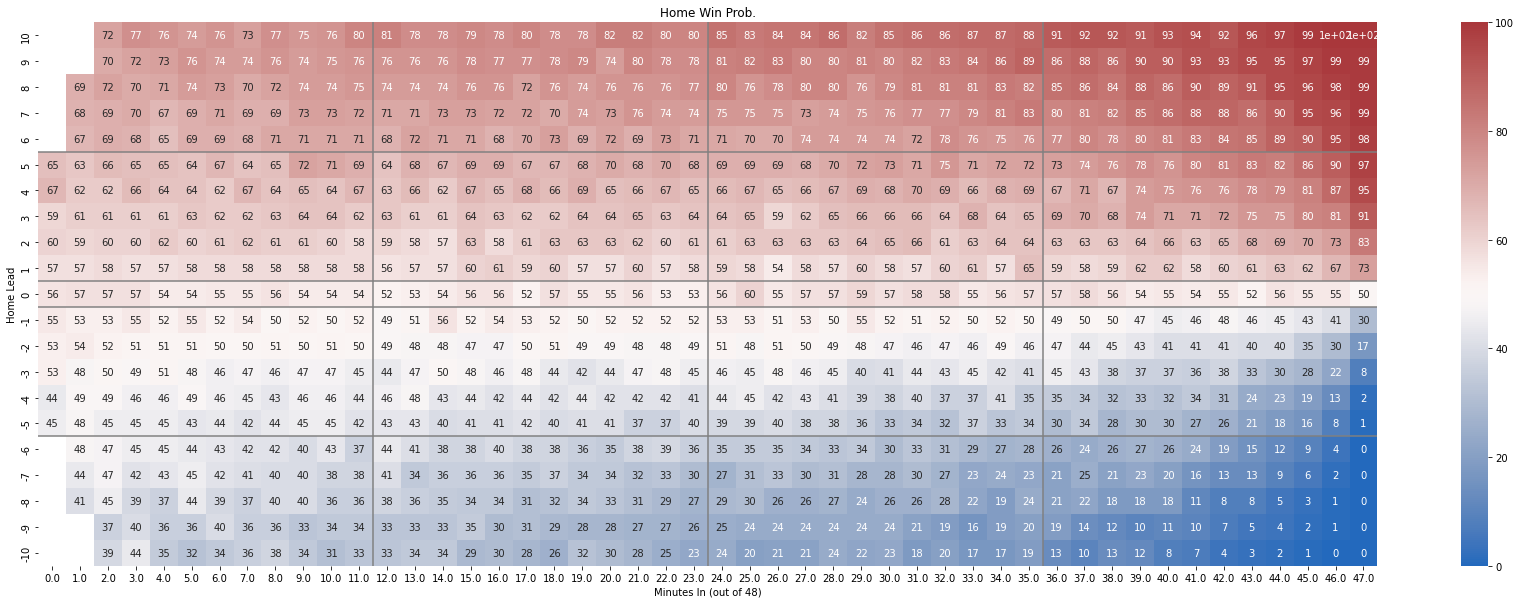

In [738]:
time_mod = 1
score_mod = 1

x = m.drop_duplicates(subset=['game_id', 'mins', 'home_lead']).groupby(["mins", "home_lead"]).agg({'home_win': ['count', 'mean']})['home_win'].reset_index().rename(columns={'mean':'win_pct'})
x['win_pct'] = (x['win_pct'] * 100).astype(int)
x = x.loc[x['count'] >= 50]
x = x.pivot(index='home_lead', columns='mins', values='win_pct')
x.index = np.array(list(x.index)) * score_mod
x.columns = np.array(list(x.columns)) * time_mod

fig, ax = plt.subplots(figsize=(30, 10))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
ax.axhline(10, color='gray')
ax.axhline(11, color='gray')
ax.axhline(5, color='gray')
ax.axhline(16, color='gray')
sns.heatmap(x.loc[10:-10:-1, 0:47], annot=True, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Home Win Prob.");



___

# XGB

In [739]:
# mod = XGBClassifier(
#     objective='binary:logistic',
#     eval_metric='logloss',
#     use_label_encoder=False,
#     min_child_weight=50,
#     colsample_bylevel=0.9,
#     subsample=0.9
# )

# params = [
#     {
#         'max_depth': [14],
#         'n_estimators': [300],
#         'eta': [.01],
#         'min_child_weight': [5],
#         'reg_lambda': [.5],
#         'gamma': [3],
#     }
# ]

# m_ = m.loc[(m['mins'] < 48)]
# X = m_[['home_ranking', 'vis_ranking', 'home_lead', 'mins']].to_numpy()
# y = m_['home_win'].astype(int).to_numpy()
# grid_search = GridSearchCV(mod, params, scoring="neg_log_loss", n_jobs=-1, cv=2)
# grid_result = grid_search.fit(X, y)
# best_params = grid_search.best_params_ # {'eta': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 50}
# mod = grid_search.best_estimator_
# print(grid_search.best_score_)
# print(best_params)


In [740]:
# cutoff = "2021-09-01"
# # features = [c for c in m.columns if c not in ['game_id', 'date', 'home', 'vis', 'home_win', 'time', 'home_score', 'vis_score']]
# # features = ['home_lead', 'mins', 'points', 'home_ranking', 'vis_ranking', 'home_off_eff', 'vis_off_eff', 'home_def_eff', 'vis_def_eff', 'home_avg_ppm', 'vis_avg_ppm', 'home_tsp', 'vis_tsp', ]
# features = ['home_lead', 'mins', 'ppm', 'home_ranking', 'vis_ranking', 'home_off_eff', 'vis_off_eff']
# m_ = m.loc[m['time'] < 48]
# X_train = m_.loc[m_['date'] <= cutoff, features].to_numpy()
# X_test = m_.loc[m_['date'] > cutoff, features].to_numpy()
# y_train = m_.loc[m_['date'] <= cutoff, 'home_win'].astype(int).to_numpy()
# y_test = m_.loc[m_['date'] > cutoff, 'home_win'].astype(int).to_numpy()

# mod = XGBClassifier(
#     objective='binary:logistic',
#     eval_metric='logloss',
#     use_label_encoder=False,
#     ##
#     max_depth=8,
#     n_estimators=5000,
#     eta=.01,
#     min_child_weight=250,
#     reg_lambda=.5,
#     gamma=0,
#     max_delta_step=5
#     ##
# )

# mod.fit(X=X_train, y=y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0, early_stopping_rounds=10)
# results = mod.evals_result()
# train_loglosses = results['validation_0']['logloss']
# test_loglosses = results['validation_1']['logloss']

# fig, ax = plt.subplots(2, 1, figsize=(9, 10))
# sns.lineplot(x=range(len(train_loglosses)), y=train_loglosses, label="train", color='blue', ax=ax[0])
# sns.lineplot(x=range(len(test_loglosses)), y=test_loglosses, label="test", color='red', ax=ax[1])
# ax[0].grid()
# ax[1].grid()
# sns.despine()




In [741]:
# # Get dummy data
# mins = np.arange(0, 48)
# home_leads = np.arange(-10, 11)
# n_combos = len(mins)*len(home_leads)
# dummy_row = pd.DataFrame(m[features].mean()).T
# dummy_data = pd.concat([dummy_row]*n_combos).reset_index(drop=True)
# dummy_data['mins'] = np.tile(mins, len(home_leads))
# dummy_data['home_lead'] = np.repeat(home_leads, len(mins))
# dummy_data['home_ranking'] = 0
# dummy_data['vis_ranking'] = 0

# # Predict
# dummy_data['yhat'] = mod.predict_proba(dummy_data)[:,1]

# # Pivot
# panel = dummy_data.pivot(index='home_lead', columns='mins', values='yhat')

# # Plot
# fig, ax = plt.subplots(figsize=(20, 10))
# ax.axvline(12, color='gray')
# ax.axvline(24, color='gray')
# ax.axvline(36, color='gray')
# ax.axhline(10, color='gray')
# ax.axhline(11, color='gray')
# ax.axhline(5, color='gray')
# ax.axhline(16, color='gray')
# sns.heatmap(panel[::-1]*100, annot=True, cmap="vlag")
# ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


In [742]:
# # Get dummy data
# mins = np.arange(0, 48)
# home_leads = np.arange(-10, 11)
# n_combos = len(mins)*len(home_leads)
# dummy_row = pd.DataFrame(m[features].mean()).T
# dummy_data = pd.concat([dummy_row]*n_combos).reset_index(drop=True)
# dummy_data['mins'] = np.tile(mins, len(home_leads))
# dummy_data['home_lead'] = np.repeat(home_leads, len(mins))
# dummy_data['home_ranking'] = .5
# dummy_data['vis_ranking'] = -.5

# # Predict
# dummy_data['yhat'] = mod.predict_proba(dummy_data)[:,1]

# # Pivot
# panel = dummy_data.pivot(index='home_lead', columns='mins', values='yhat')

# # Plot
# fig, ax = plt.subplots(figsize=(20, 10))
# ax.axvline(12, color='gray')
# ax.axvline(24, color='gray')
# ax.axvline(36, color='gray')
# ax.axhline(10, color='gray')
# ax.axhline(11, color='gray')
# ax.axhline(5, color='gray')
# ax.axhline(16, color='gray')
# sns.heatmap(panel[::-1]*100, annot=True, cmap="vlag")
# ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


In [743]:
# # Get dummy data
# mins = np.arange(0, 48)
# home_leads = np.arange(-10, 11)
# n_combos = len(mins)*len(home_leads)
# dummy_row = pd.DataFrame(m[features].mean()).T
# dummy_data = pd.concat([dummy_row]*n_combos).reset_index(drop=True)
# dummy_data['mins'] = np.tile(mins, len(home_leads))
# dummy_data['home_lead'] = np.repeat(home_leads, len(mins))
# dummy_data['home_ranking'] = -.5
# dummy_data['vis_ranking'] = .5

# # Predict
# dummy_data['yhat'] = mod.predict_proba(dummy_data)[:,1]

# # Pivot
# panel = dummy_data.pivot(index='home_lead', columns='mins', values='yhat')

# # Plot
# fig, ax = plt.subplots(figsize=(20, 10))
# ax.axvline(12, color='gray')
# ax.axvline(24, color='gray')
# ax.axvline(36, color='gray')
# ax.axhline(10, color='gray')
# ax.axhline(11, color='gray')
# ax.axhline(5, color='gray')
# ax.axhline(16, color='gray')
# sns.heatmap(panel[::-1]*100, annot=True, cmap="vlag")
# ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");

In [744]:
# pd.Series(dict(zip(features, mod.feature_importances_))).sort_values(ascending=False).head(30)

___

In [416]:
# prevs = [5]
# for prev in prevs:
#     m[f'home_lead_prev_{prev}'] = m['home_lead'].shift(prev)
#     m.loc[m['game_id'].shift(prev) != m['game_id'], f'home_lead_prev_{prev}'] = np.nan
    

___

# FFNN

In [775]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, Activation
from sklearn.preprocessing import StandardScaler


In [903]:
## Get features
# features = ['home_off_eff', 'vis_off_eff', 'home_def_eff', 'vis_def_eff', 'home_avg_ppm', 'vis_avg_ppm', 'home_tsp', 'vis_tsp']
features = ['home_lead', 'time_left', 'ppm', 'home_ranking', 'vis_ranking']#, 'home_off_eff', 'vis_off_eff']
features = ['home_lead', 'time_left', 'ppm', 'home_ranking', 'vis_ranking', 'home_lead_pml']#, 'home_off_eff', 'vis_off_eff']

## Get training/test
cutoff = "2021-09-01"
m_ = m.loc[m['time'] < 48].dropna(axis=0).reset_index(drop=True).copy(deep=True)
m_['time_left'] = np.log(48-m_['time'])
m_['home_lead_pml'] = m_['home_lead'] / np.sqrt(48-m_['time'])
X_train = m_.loc[m_['date'] <= cutoff, features].to_numpy()
X_test = m_.loc[m_['date'] > cutoff, features].to_numpy()
y_train = m_.loc[m_['date'] <= cutoff, 'home_win'].astype(int).to_numpy()
y_test = m_.loc[m_['date'] > cutoff, 'home_win'].astype(int).to_numpy()

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [913]:
model = keras.Sequential()
model.add(keras.Input(shape=(X_train_scaled.shape[1],)))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(1, activation='sigmoid'))
print(model.summary())

# opt = keras.optimizers.Adam(learning_rate=1e-5)
opt = keras.optimizers.Adam(learning_rate=2.5e-6)
model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=['binary_crossentropy', 'acc']
)

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(
    X_train_scaled,
    y_train,
    batch_size=32,
    epochs=500,
    validation_data=(X_test_scaled, y_test),
    callbacks=[callback],
    verbose=2
)


Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_197 (Dense)            (None, 16)                112       
_________________________________________________________________
dense_198 (Dense)            (None, 32)                544       
_________________________________________________________________
dense_199 (Dense)            (None, 8)                 264       
_________________________________________________________________
dense_200 (Dense)            (None, 1)                 9         
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
28832/28832 - 13s - loss: 0.6035 - binary_crossentropy: 0.6035 - acc: 0.7255 - val_loss: 0.5451 - val_binary_crossentropy: 0.5451 - val_acc: 0.7397
Epoch 2/500
28832/28832 - 13s - loss: 0.5016 - binary_crossentropy: 0.5016 - acc: 0.7538

In [914]:
# name = "16_32_8"
# model.save(f'model/{name}')
# model = keras.models.load_model(f'model/{name}')


INFO:tensorflow:Assets written to: model/16_32_8/assets


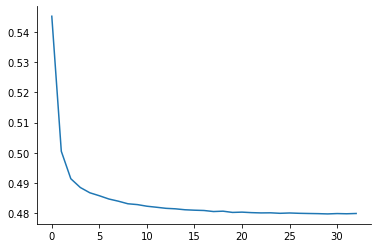

In [915]:
i=0
sns.lineplot(x=np.arange(len(history.history['val_loss'][-i:])), y=history.history['val_loss'][-i:])
sns.despine()

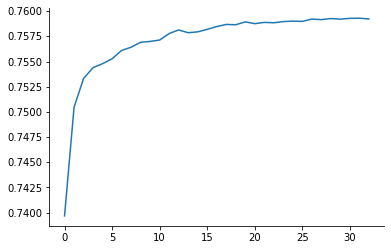

In [916]:
sns.lineplot(x=np.arange(len(history.history['val_acc'])), y=history.history['val_acc'])
sns.despine()

In [917]:
def get_win_probs_by_game_state(model, m, ss, home_ranking=0, vis_ranking=0, mins=np.arange(0, 48), home_leads=np.arange(-10, 11), mean_replacers=None):
    n_combos = len(mins)*len(home_leads)
    mean_replacers = mean_replacers if mean_replacers is not None else dict()
    dummy_row = pd.DataFrame(m[features].mean()).T
    for feature, value in mean_replacers.items():
        dummy_row.loc[0, feature] = value
    dummy_data = pd.concat([dummy_row]*n_combos).reset_index(drop=True)
    time = np.tile(mins, len(home_leads))
    dummy_data['time_left'] = np.log(48-time)
    dummy_data['home_lead'] = np.repeat(home_leads, len(mins))
    dummy_data['home_lead_pml'] = dummy_data['home_lead']/np.sqrt(48-time)
    dummy_data['home_ranking'] = home_ranking
    dummy_data['vis_ranking'] = vis_ranking
    dummy_data_scaled = ss.transform(dummy_data.to_numpy())
    dummy_data['yhat'] = model.predict(dummy_data_scaled)[:,0]
    dummy_data['time'] = time
    panel = dummy_data.pivot(index='home_lead', columns='time', values='yhat')
    return panel

    

In [ ]:
# Get win probs
panel_even = get_win_probs_by_game_state(model, m_, ss)

# Plot
fig, ax = plt.subplots(figsize=(25, 12))
annot = False
annot = True
if annot:
    ax.axvline(12, color='gray')
    ax.axvline(24, color='gray')
    ax.axvline(36, color='gray')
    ax.axhline(10, color='gray')
    ax.axhline(11, color='gray')
    ax.axhline(5, color='gray')
    ax.axhline(16, color='gray')
    sns.heatmap(panel_even[::-1]*100, annot=True, cmap="vlag")
else:
    sns.heatmap(panel_even[::-1]*100, annot=False, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


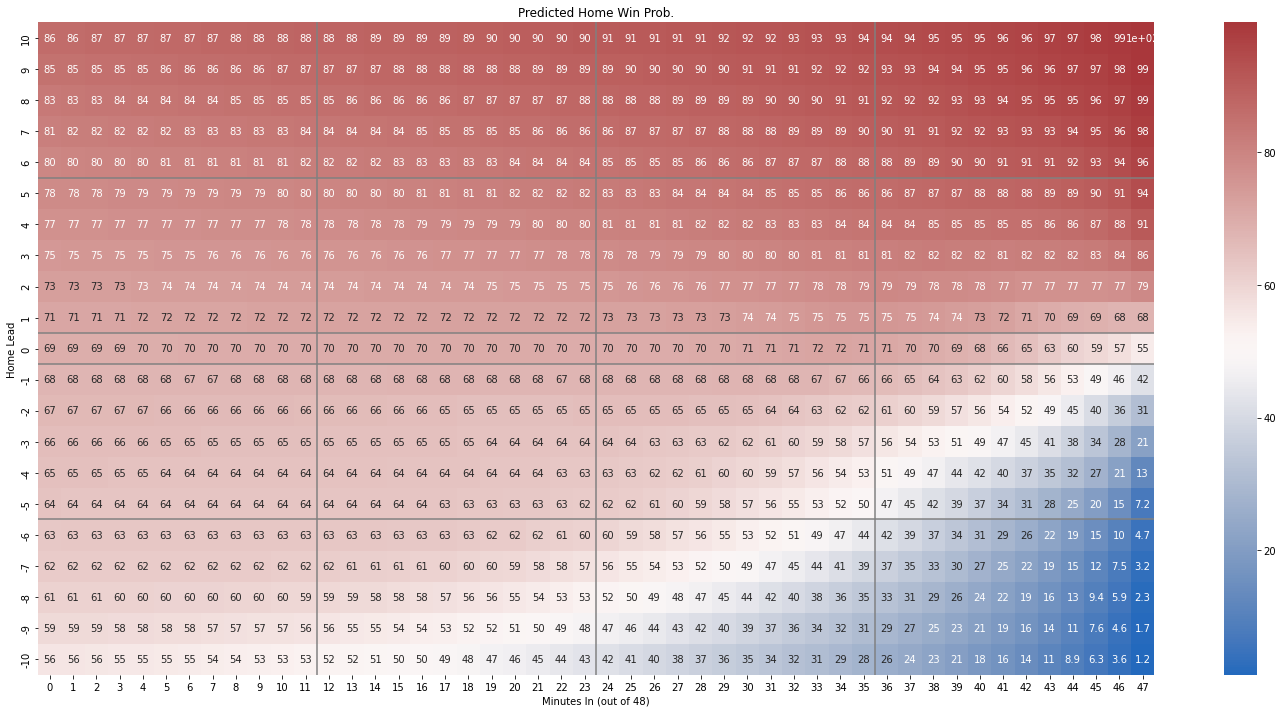

In [919]:
# Get win probs
panel_home_fav = get_win_probs_by_game_state(model, m_, ss, home_ranking=.5, vis_ranking=-.5)

# Plot
fig, ax = plt.subplots(figsize=(25, 12))
annot = False
annot = True
if annot:
    ax.axvline(12, color='gray')
    ax.axvline(24, color='gray')
    ax.axvline(36, color='gray')
    ax.axhline(10, color='gray')
    ax.axhline(11, color='gray')
    ax.axhline(5, color='gray')
    ax.axhline(16, color='gray')
    sns.heatmap(panel_home_fav[::-1]*100, annot=True, cmap="vlag")
else:
    sns.heatmap(panel_home_fav[::-1]*100, annot=False, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


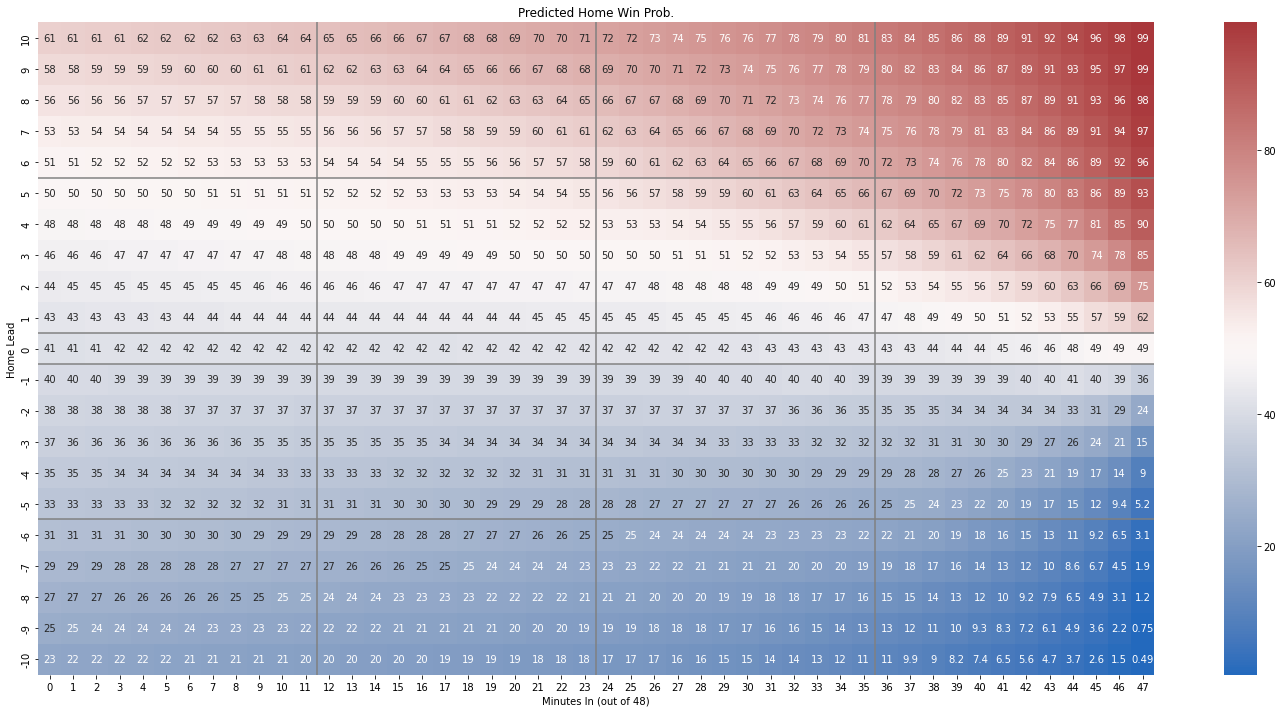

In [920]:
# Get win probs
panel_vis_fav = get_win_probs_by_game_state(model, m_, ss, home_ranking=-.5, vis_ranking=.5)

# Plot
fig, ax = plt.subplots(figsize=(25, 12))
annot = False
annot = True
if annot:
    ax.axvline(12, color='gray')
    ax.axvline(24, color='gray')
    ax.axvline(36, color='gray')
    ax.axhline(10, color='gray')
    ax.axhline(11, color='gray')
    ax.axhline(5, color='gray')
    ax.axhline(16, color='gray')
    sns.heatmap(panel_vis_fav[::-1]*100, annot=True, cmap="vlag")
else:
    sns.heatmap(panel_vis_fav[::-1]*100, annot=False, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


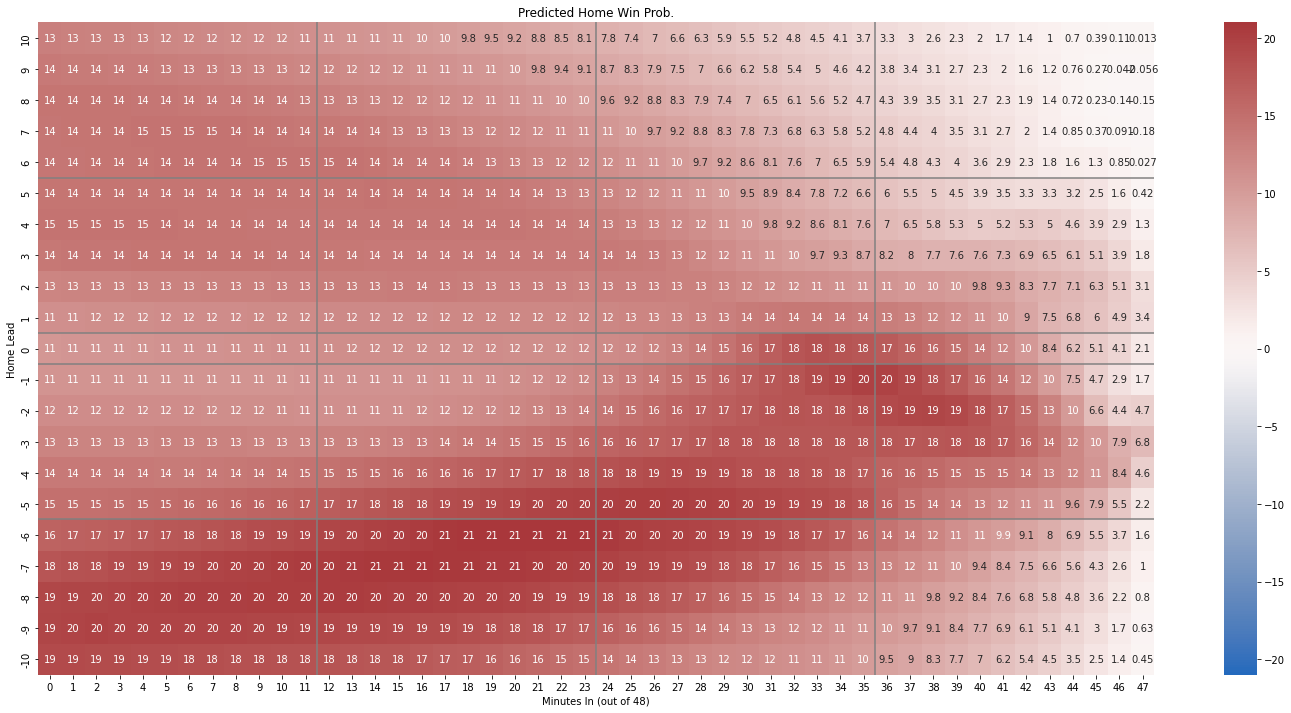

In [921]:
# Plot
fig, ax = plt.subplots(figsize=(25, 12))
annot = False
annot = True
panel_diff = (panel_home_fav[::-1] - panel_even[::-1])*100
vmax = max(-panel_diff.min().min(), panel_diff.max().max())
if annot:
    ax.axvline(12, color='gray')
    ax.axvline(24, color='gray')
    ax.axvline(36, color='gray')
    ax.axhline(10, color='gray')
    ax.axhline(11, color='gray')
    ax.axhline(5, color='gray')
    ax.axhline(16, color='gray')
    sns.heatmap(panel_diff, annot=True, cmap="vlag", vmin=-vmax, vmax=vmax)
else:
    sns.heatmap(panel_diff, annot=False, cmap="vlag", vmin=-vmax, vmax=vmax)
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


____

In [765]:
sbs = pd.read_csv("data/score_by_score/2021-22.csv")
sbs.loc[sbs['date'] == "2022-03-03"].sample(5)

,game_id,date,home,vis,time,home_score,vis_score,home_win
89759,22100942,2022-03-03,TOR,DET,38.82,85,92,False
89717,22100942,2022-03-03,TOR,DET,22.08,52,53,False
70831,22100710,2022-03-03,ATL,CHI,26.95,67,68,True
89799,22100943,2022-03-03,DAL,GSW,4.57,16,9,True
101481,22100944,2022-03-03,SAS,SAC,13.72,30,34,False


In [786]:
game_sbs = sbs.loc[sbs['game_id'] == 22100943]
game_sbs

,game_id,date,home,vis,time,home_score,vis_score,home_win
89785,22100943,2022-03-03,DAL,GSW,0.00,0,0,True
89786,22100943,2022-03-03,DAL,GSW,0.38,2,0,True
89787,22100943,2022-03-03,DAL,GSW,0.70,2,2,True
89788,22100943,2022-03-03,DAL,GSW,0.97,3,2,True
89789,22100943,2022-03-03,DAL,GSW,0.97,4,2,True
...,...,...,...,...,...,...,...,...
89895,22100943,2022-03-03,DAL,GSW,45.48,115,111,True
89896,22100943,2022-03-03,DAL,GSW,45.73,118,111,True
89897,22100943,2022-03-03,DAL,GSW,46.02,118,113,True
89898,22100943,2022-03-03,DAL,GSW,47.07,120,113,True


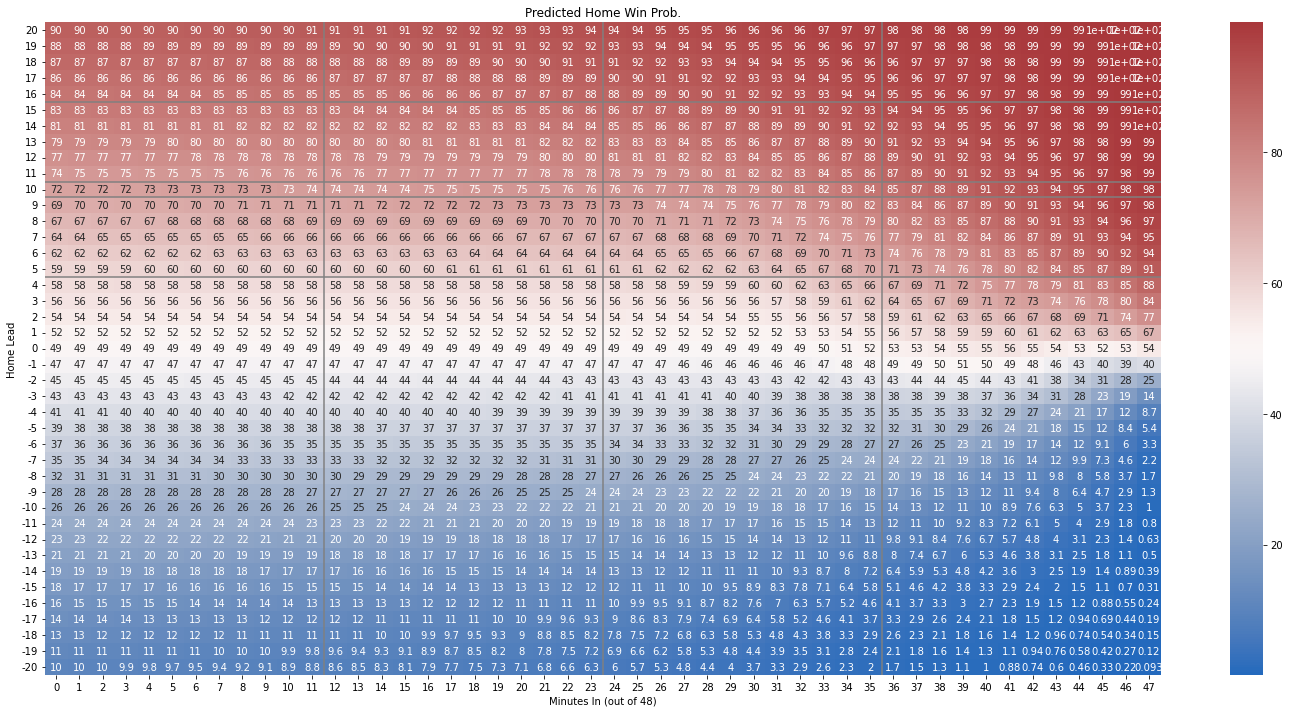

In [787]:
home = game_sbs.iloc[-1]['home']
vis = game_sbs.iloc[-1]['vis']
home_ranking = rbd.sort_values("date").groupby("team")['ranking'].last()[home]
vis_ranking = rbd.sort_values("date").groupby("team")['ranking'].last()[vis]
panel = get_win_probs_by_game_state(model, m_, ss, home_ranking=home_ranking, vis_ranking=vis_ranking, home_leads=np.arange(-20, 21))

# Plot
fig, ax = plt.subplots(figsize=(25, 12))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
ax.axhline(10, color='gray')
ax.axhline(11, color='gray')
ax.axhline(5, color='gray')
ax.axhline(16, color='gray')
sns.heatmap(panel[::-1]*100, annot=True, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");

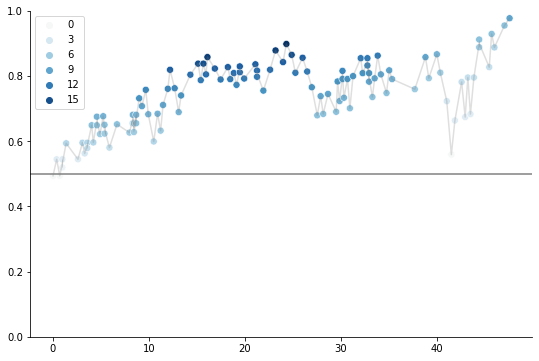

In [788]:
probs = list()
home_leads = list()
time = list()
for _, row in game_sbs.iterrows():
    probs.append(panel.loc[row['home_score']-row['vis_score'], np.floor(row['time'])])
    home_leads.append(row['home_score']-row['vis_score'])
    time.append(row['time'])
probs = [prob for prob in probs]

fig, ax = plt.subplots(figsize=(9, 6))
max_lead = max(-min(home_leads), max(home_leads))
sns.scatterplot(x=time, y=probs, hue=home_leads, palette="RdBu", hue_norm=(-max_lead, max_lead), s=50)
sns.lineplot(x=time, y=probs, color="gray", alpha=0.25) 
ax.axhline(0.5, color='gray')
ax.set_ylim(0, 1)
# ax.grid()
sns.despine()

